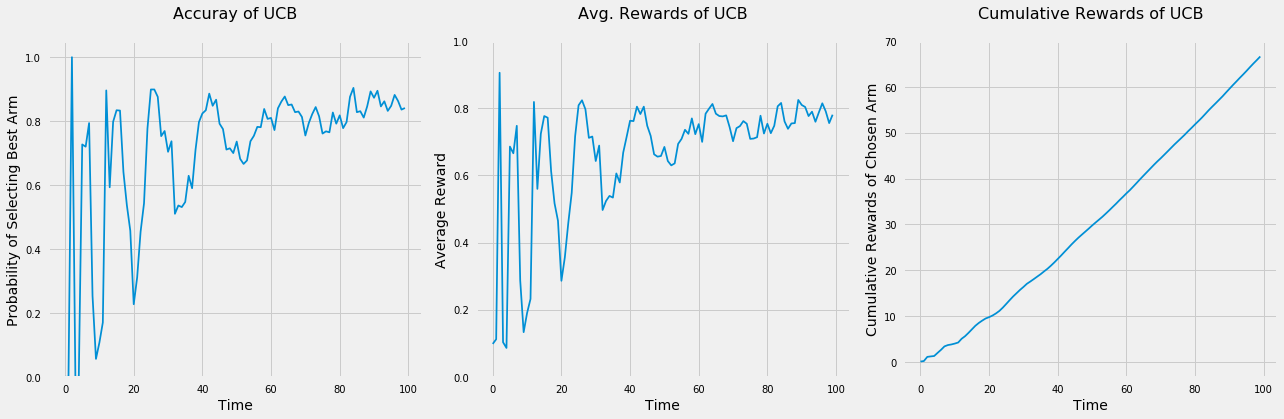

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")


class UCB:
    def __init__(self, counts=None, values=None):
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        n_arms = len(self.counts)

        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm

        ucb_values = np.zeros(n_arms)
        n = np.sum(self.counts)
        for arm in range(n_arms):
            bonus = np.sqrt((2 * np.log(n)) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + bonus

        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = value * ((n - 1) / n) + reward / n
        self.values[chosen_arm] = new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0
    
def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "UCB": UCB,
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    if hyper_params is None:
        algo = ALGORITHMS[alg_name]()
        chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations

        fig, axes = plt.subplots(1, 3, figsize=fig_size)
        axes[0].plot(average_probs)
        axes[0].set_xlabel("Time", fontsize=14)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
        axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
        axes[0].set_ylim([0, 1.05])
        axes[1].plot(average_rewards)
        axes[1].set_xlabel("Time", fontsize=14)
        axes[1].set_ylabel("Average Reward", fontsize=14)
        axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[1].set_ylim([0, 1.0])
        axes[2].plot(cum_rewards)
        axes[2].set_xlabel("Time", fontsize=14)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
        axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
        plt.tight_layout()

    else:
        fig, axes = plt.subplots(1, 3, figsize=fig_size)
        for hyper_param in hyper_params:
            algo = ALGORITHMS[alg_name](hyper_param)
            chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
            average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations
            axes[0].plot(average_probs, label=label + "= %s" %hyper_param)
            axes[0].set_xlabel("Time", fontsize=14)
            axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
            axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
            axes[0].legend()
            axes[0].set_ylim([0, 1.05])
            axes[1].plot(average_rewards, label=label + "= %s" %hyper_param)
            axes[1].set_xlabel("Time", fontsize=14)
            axes[1].set_ylabel("Average Reward", fontsize=14)
            axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
            axes[1].legend()
            axes[1].set_ylim([0, 1.0])
            axes[2].plot(cum_rewards, label=label + "= %s" %hyper_param)
            axes[2].set_xlabel("Time", fontsize=14)
            axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
            axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
            axes[2].legend(loc="lower right")
            plt.tight_layout()
    
np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
plot_algorithm(alg_name="UCB", arms=arms, best_arm_index=best_arm_index, num_simulations=1000, horizon=100)